In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, optimize

There are two goals for this notebook.
1. Learn how to fit including error bars (weighted least squares)
2. Learn how to estimate model parameter errors (confidence ovals)

Intuitively, data with larger errors should matter less to a fit than data with small error bars.
Also, models varying within those error bars should be similarly valid.

The main reference used is Numerical Recipes, Vol 3, Ch 15.

*First we will show example code. Mathy explanation and caveats are included at the end.*

# Example code

Here's a simple example fitting a line.
We generate some fake data using some known uncertainties.

Very often, the uncertainties are larger as we go to an extreme parameter, so we make a toy error function that gets larger as you go to large values.

In [2]:
## Define functions
# f = line, g = error function
def f(x,m,b):
    """ A line """
    return m*x + b
def g(x,e,a,x0):
    """ Error that changes with x """
    return e + a*(x-x0)**2
## Define input ("true") parameters.
m0 = .5 # slope
b0 = 2  # intercept
e0 = .1 # minimum error
a0 = .2 # amount the error changes as you go away from x0
x0 = 1  # minimum error point

## Generate fake data, assuming normally distributed/gaussian errors
np.random.seed(1230498)
x = np.linspace(0,10)
yerr = np.random.normal(0,g(x,e0,a0,x0),size=len(x))
y = f(x,m0,b0) + yerr
sigma_est = g(x,e0,a0,x0)

<Container object of 3 artists>

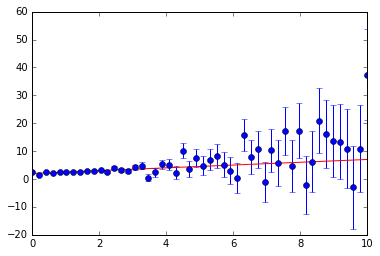

In [3]:
plt.plot(x,f(x,m0,b0),'r-')
plt.errorbar(x,y,yerr=sigma_est,fmt='o')

In [4]:
# Fit data without including errors
popt, pcov = optimize.curve_fit(f,x,y)

In [5]:
merr = np.sqrt(pcov[0,0])
berr = np.sqrt(pcov[1,1])
print "m={:.2f} +/- {:.2f} (True={:.2f})".format(popt[0],merr,m0)
print "b={:.2f} +/- {:.2f} (True={:.2f})".format(popt[1],berr,b0)

m=1.30 +/- 0.28 (True=0.50)
b=0.04 +/- 1.62 (True=2.00)


Note: the errors above are tricky, because m and b are correlated! 

In [6]:
print pcov[0,1] # the covariance between m and b

-0.391402993152


A better way to visualize this is with a confidence oval.

0.00419726361958


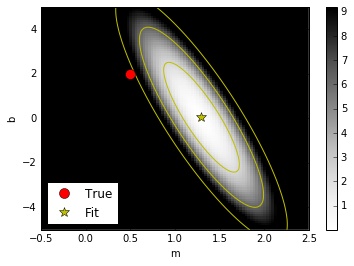

In [7]:
## generate a grid of m and b to calculate chi2
N = 100
mgrid = np.linspace(-0.5,2.5,N)
dmgrid = mgrid - popt[0]
bgrid = np.linspace(-5,5,N)
dbgrid = bgrid - popt[1]

icov = np.linalg.inv(pcov)
chi2grid = np.zeros((N,N))

for i in range(N):
    for j in range(N):
        dmb = np.array([dmgrid[i],dbgrid[j]])
        chi2grid[i,j] = dmb.dot(icov.dot(dmb))
chi2min = np.min(chi2grid)
print chi2min

mmin, mmax = mgrid.min(), mgrid.max()
bmin, bmax = bgrid.min(), bgrid.max()
# TODO I think my extent is off by the grid square size
plt.imshow(chi2grid.T, origin="lower", extent=[mmin,mmax,bmin,bmax],
           cmap="Greys",interpolation='none',
           vmin=np.min(chi2grid),vmax=np.min(chi2grid)+9.21,aspect='auto')
levels = np.min(chi2grid) + np.array([2.30,6.18,11.80])
plt.plot([m0],[b0],'ro',ms=10,label="True")
plt.plot([popt[0]],[popt[1]],'y*',ms=10,label="Fit")
plt.colorbar()
# Add contours
X,Y = np.meshgrid(mgrid,bgrid)
plt.contour(X.T,Y.T,chi2grid,levels=levels,colors='y')
plt.xlabel("m")
plt.ylabel("b")
plt.xlim(mmin,mmax)
plt.ylim(bmin,bmax)
plt.legend(loc="lower left",numpoints=1);
# Note that the True point is not within the 99% confidence interval!

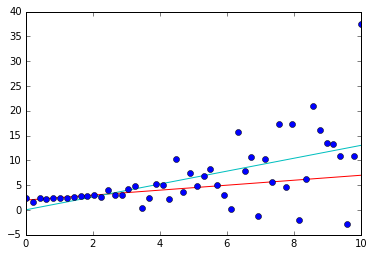

In [8]:
# Plot the actual fitted line against the data
plt.plot(x,f(x,m0,b0),'r-')
plt.plot(x,f(x,popt[0],popt[1]),'c-')
plt.plot(x,y,'o')

You can see by eye that it fails pretty hard.

Let's also try plotting a bunch of samples from covariance matrix that the fit thinks are valid.

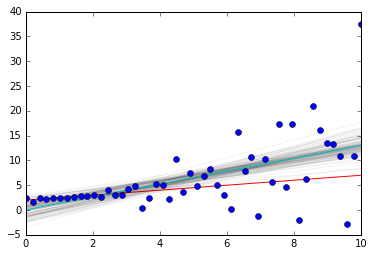

In [9]:
paramsamples = np.random.multivariate_normal(popt, pcov, size=100)
plt.plot(x,f(x,m0,b0),'r-')
for msample, bsample in paramsamples:
    plt.plot(x,f(x,msample,bsample),'k-',alpha=.05)
plt.plot(x,f(x,popt[0],popt[1]),'c-')
plt.plot(x,y,'o');

### Weighted least squares
Now let's fit it with weights

In [10]:
wopt, wcov = optimize.curve_fit(f,x,y,sigma=sigma_est)

In [11]:
wmerr = np.sqrt(wcov[0,0])
wberr = np.sqrt(wcov[1,1])
print "m={:.2f} +/- {:.2f} (True={:.2f})".format(wopt[0],wmerr,m0)
print "b={:.2f} +/- {:.2f} (True={:.2f})".format(wopt[1],wberr,b0)
print wcov[0,1]

m=0.55 +/- 0.08 (True=0.50)
b=1.90 +/- 0.10 (True=2.00)
-0.00666085745759


0.15296105569


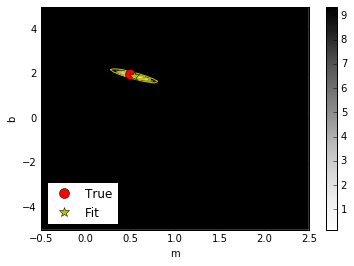

In [12]:
## generate a grid of m and b to calculate chi2
N = 100
mgrid = np.linspace(-0.5,2.5,N)
dmgrid = mgrid - wopt[0]
bgrid = np.linspace(-5,5,N)
dbgrid = bgrid - wopt[1]

iwcov = np.linalg.inv(wcov)
chi2grid = np.zeros((N,N))

for i in range(N):
    for j in range(N):
        dmb = np.array([dmgrid[i],dbgrid[j]])
        chi2grid[i,j] = dmb.dot(iwcov.dot(dmb))
chi2min = np.min(chi2grid)
print chi2min

mmin, mmax = mgrid.min(), mgrid.max()
bmin, bmax = bgrid.min(), bgrid.max()
# TODO I think my extent is off by the grid square size
plt.imshow(chi2grid.T, origin="lower", extent=[mmin,mmax,bmin,bmax],
           cmap="Greys",interpolation='none',
           vmin=np.min(chi2grid),vmax=np.min(chi2grid)+9.21,aspect='auto')
plt.plot([m0],[b0],'ro',ms=10,label="True")
plt.plot([wopt[0]],[wopt[1]],'y*',ms=10,label="Fit")
plt.colorbar()
# Add contours
X,Y = np.meshgrid(mgrid,bgrid)
plt.contour(X.T,Y.T,chi2grid,levels=levels,colors='y')
plt.xlabel("m")
plt.ylabel("b")
plt.xlim(mmin,mmax)
plt.ylim(bmin,bmax)
plt.legend(loc="lower left",numpoints=1);

(-5, 40)

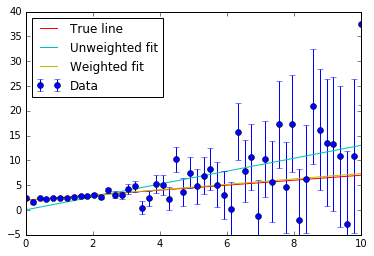

In [13]:
plt.plot(x,f(x,m0,b0),'r-',label="True line")
plt.plot(x,f(x,popt[0],popt[1]),'c-',label="Unweighted fit")
plt.plot(x,f(x,wopt[0],wopt[1]),'y-',label="Weighted fit")
plt.errorbar(x,y,yerr=sigma_est,fmt='o',label="Data")
plt.legend(loc='upper left')
plt.ylim(-5,40)

You can see that including the data errors makes the fit much less biased, and also have a smaller uncertainty that encompasses the true fit!
We can also see this by plotting samples.

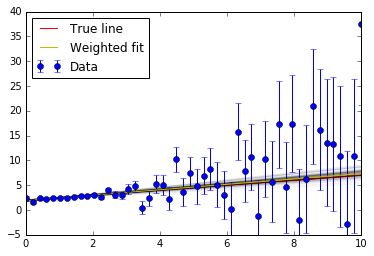

In [14]:
paramsamples = np.random.multivariate_normal(wopt, wcov, size=100)
plt.plot(x,f(x,m0,b0),'r-',label="True line")
plt.plot(x,f(x,m0,b0),'r-')
for msample, bsample in paramsamples:
    plt.plot(x,f(x,msample,bsample),'k-',alpha=.05)
plt.plot(x,f(x,wopt[0],wopt[1]),'y-',label="Weighted fit")
plt.errorbar(x,y,yerr=sigma_est,fmt='o',label="Data")
plt.ylim(-5,40)
plt.legend(loc='upper left')

The weighted fits are primarily constrained by the data that was given a small uncertainty, and it varies a lot at the larger x where the data had a larger uncertainty.

# Chi2 fitting/least squares

Suppose you are given $N$ data points, and you want to fit a model with parameters $\overrightarrow{\theta}$ (the arrow means there is one or more parameters).
The independent variables are $x_i$, the dependent variables are $y_i$, and the error for each data point is $\sigma_i$, where $i=0$ to $N-1$.

You can fit a model $\mu(x,\overrightarrow{\theta})$ with `scipy.curve_fit`, where $\mu$ is a function that takes values $x$ and parameters $\overrightarrow{\theta}$ and returns the dependent variable $y$.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

What this is doing under the hood is minimizing the following quantity. 
$$\chi^2(\overrightarrow{\theta}) = \sum_{i=0}^{N-1} \left(\frac{y_i - \mu(x_i,\overrightarrow{\theta})}{\sigma_i}\right)^2$$

Picking the parameter(s) $\overrightarrow{\theta}$ that minimize this function is called $\chi^2$ fitting, and it is the default thing that is done in most fitting algorithms.
The algorithm is essentially an attempt to find the best $\overrightarrow{\theta}$ with the minimum number of function evaluations of $\mu$ (i.e. in the least number of steps).

Note: in general, if you give a fitting algorithm no errors, it will assume all the $\sigma_i$ are equal (usually to all equal to 1). In this case, the algorithm will find the correct optimum, but the error estimates it gives are meaningless.

### Other functions to minimize

You can imagine that maybe you want to minimize something like this instead, which is the absolute value:

$$F(\overrightarrow{\theta}) = \sum_{i=0}^{N-1} \left|\frac{y_i - \mu(x_i,\overrightarrow{\theta})}{\sigma_i}\right|$$

How does this differ from $\chi^2$ in treating outliers? e.g., is it more or less sensitive to outliers?

### Some math motivation
One reason you might think the sum of squares is a good thing to minimize is because it has a nice relation to the gaussian random variable.

Assume that $y_i$ is a normal (a.k.a. gaussian) random variable with mean $\mu(x_i,\overrightarrow{\theta})$ and standard deviation $\sigma_i$. In symbols:
$$ y_i = \mathcal{N}(\mu(x_i,\overrightarrow{\theta}),\sigma_i^2)$$

What this means is that $\frac{y_i - \mu(x_i,\overrightarrow{\theta})}{\sigma_i}$ is a normal random variable with mean 0 and variance 1. (If you have taken a statistics class, you might have called this the $z$-score, and used it to calculate $p$-values or confidence intervals.)

The assumption of Gaussian errors is a very specific assumption.
It's often a good (or good enough) assumption, because of the central limit theorem.
And the methods for fitting least squares are very fast and usually numerically stable.
So in astronomy and physics, people will often implicitly make this assumption.

(e.g., it's numerically harder to minimize the absolute deviation compared to $\chi^2$ because the absolute value has discontinuities in the derivative, and an estimate of the derivative is used in the minimization process).

# Determining parameter errors

When you run a chi2 fit, the fitter should return a "covariance matrix".
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

The values in this covariance matrix will only make sense if you specified the errors on your data $\sigma_i$.

If you fit $M$ parameters, then you have a covariance matrix of size $M \times M$
Let's call this matrix $\mathcal{C}$, and individual elements of the matrix are $\mathcal{C}_{ij}$.
Note that $\mathcal{C}_{ij} = \mathcal{C}_{ji}$, i.e. the matrix is symmetric.

If you only cared about one fitted parameter (with index $i$), you can estimate a "$1\sigma$" error as $\sqrt{\mathcal{C}_{ii}}$.

If you cared about the _correlated_ errors for multiple parameters $\nu \leq M$:
then take the square submatrix of $\mathcal{C}$ that includes the parameters of interest.
Call that submatrix $\mathcal{C}_{\rm proj}$.
Then the equation for the elliptical boundary is given by
$$ \Delta = \delta\overrightarrow{\theta} \mathcal{C}_{\rm proj}^{-1} \delta\overrightarrow{\theta} $$
where $\Delta$ is a number you choose and $\delta\overrightarrow{\theta}$ is the offset in the parameters.

One way you might choose $\Delta$ is in the table below (taken from Numerical Recipes). $\nu$ is the number of parameters. $p$ is the percentile you want. See caveats below.

The intuition here is that $\chi^2(\theta)$ is a likelihood, and you have found a bump.
You can fit a multidimensional Gaussian to that surface, and take confidence intervals assuming that.

### WARNING:
This error ellipse is always something you can calculate.
However, interpreting what the $\Delta\chi^2$ means is something you have to be careful of.

Often you want to do something like determine a $1\sigma$ confidence interval or a 90\% confidence interval. The relation between $\Delta\chi^2$, the percentile (or "sigma"), and the number of parameters $\nu$ can be determined here:

<img src="https://alexji.github.io/img/chi2table.png">

You can also use `scipy.stats.chi2.ppf` if you have more parameters or different percentiles you care about.

HOWEVER: using these $\Delta\chi^2$ values is VERY sensitive to the assumption of (1) Gaussian errors in your data, and (2) Gaussian approximation of the fitted parameters.
So you should be careful.

In general if your errors are not normal, you are "allowed" to:
* fit for parameters by minimizing $\chi^2$
* use a contour of constant $\Delta\chi^2$ as the boundary of your confidence region
* use a Monte Carlo simulation or analytic calculation to find _which_ contour is the right one
* give the covariance matrix $\mathcal{C}_{ij}$ as the "formal covariance matrix of the fit"

But you CANNOT
* use this table or similar formulas to relate $\Delta\chi^2$, $\mathcal{C}_{ij}$, and the confidence level.

If this comes up in your research, feel free to talk to Alex about what sort of things you might do instead.

Ultimately, assumption (1) is a choice you have to make. You could decide to assume something else, e.g. your data is drawn from a Poisson process (which is in fact a good model for e.g. counts in a CCD; but when counts > 5-10, a normal distribution is a reasonable approximation to the poisson distribution).

Assumption (2) is something that is often violated. The true correlations between parameters are often not nice ellipses. If you suspect this is the case for your parameters, Markov Chain Monte Carlo (MCMC) methods can be used as a way to explore an arbitrarily shaped distribution. Doing that is beyond the scope of this exercise.

# Errors in both x and y
Note that all these examples assume x has no errors, and y has errors.
This is a reasonable approximation e.g. if x is time and y is flux.
However, in many cases there are significant uncertainties in both.
In this case, you should write down a model that includes uncertainties in both parameters.
See this link for much more detail:
https://arxiv.org/abs/1008.4686

